![A soccer pitch for an international match.](soccer-pitch.jpg)

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [254]:
# Start your code here!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
from scipy.stats import t, shapiro
from scipy.stats.distributions import norm
from statsmodels.graphics.gofplots import qqplot

In [255]:
men_results = pd.read_csv('men_results.csv')
women_results = pd.read_csv('women_results.csv')

In [256]:
print(men_results.head())

   Unnamed: 0        date home_team  ... home_score  away_score  tournament
0           0  1872-11-30  Scotland  ...          0           0    Friendly
1           1  1873-03-08   England  ...          4           2    Friendly
2           2  1874-03-07  Scotland  ...          2           1    Friendly
3           3  1875-03-06   England  ...          2           2    Friendly
4           4  1876-03-04  Scotland  ...          3           0    Friendly

[5 rows x 7 columns]


In [257]:
print(women_results.head())

   Unnamed: 0        date home_team  ... home_score  away_score        tournament
0           0  1969-11-01     Italy  ...          1           0              Euro
1           1  1969-11-01   Denmark  ...          4           3              Euro
2           2  1969-11-02   England  ...          2           0              Euro
3           3  1969-11-02     Italy  ...          3           1              Euro
4           4  1975-08-25  Thailand  ...          3           2  AFC Championship

[5 rows x 7 columns]


In [258]:
men_results.shape

(44353, 7)

In [259]:
women_results.shape

(4884, 7)

In [260]:
men_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44353 entries, 0 to 44352
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44353 non-null  int64 
 1   date        44353 non-null  object
 2   home_team   44353 non-null  object
 3   away_team   44353 non-null  object
 4   home_score  44353 non-null  int64 
 5   away_score  44353 non-null  int64 
 6   tournament  44353 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.4+ MB


In [261]:
women_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4884 entries, 0 to 4883
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4884 non-null   int64 
 1   date        4884 non-null   object
 2   home_team   4884 non-null   object
 3   away_team   4884 non-null   object
 4   home_score  4884 non-null   int64 
 5   away_score  4884 non-null   int64 
 6   tournament  4884 non-null   object
dtypes: int64(3), object(4)
memory usage: 267.2+ KB


In [262]:
men_results.describe()

,Unnamed: 0,home_score,away_score
count,44353.000000,44353.000000,44353.000000
mean,22176.000000,1.740559,1.178793
std,12803.752581,1.748722,1.394580
min,0.000000,0.000000,0.000000
25%,11088.000000,1.000000,0.000000
50%,22176.000000,1.000000,1.000000
75%,33264.000000,2.000000,2.000000
max,44352.000000,31.000000,21.000000


In [263]:
women_results.describe()

,Unnamed: 0,home_score,away_score
count,4884.000000,4884.000000,4884.000000
mean,2441.500000,2.272727,1.431409
std,1410.033688,2.736377,1.974651
min,0.000000,0.000000,0.000000
25%,1220.750000,0.000000,0.000000
50%,2441.500000,1.000000,1.000000
75%,3662.250000,3.000000,2.000000
max,4883.000000,24.000000,24.000000


In [264]:
men_results['tournament'].value_counts()

Friendly                                17519
FIFA World Cup qualification             7878
UEFA Euro qualification                  2585
African Cup of Nations qualification     1932
FIFA World Cup                            964
                                        ...  
Real Madrid 75th Anniversary Cup            1
Évence Coppée Trophy                        1
Copa Confraternidad                         1
TIFOCO Tournament                           1
FIFA 75th Anniversary Cup                   1
Name: tournament, Length: 141, dtype: int64

In [265]:
# Convert dates to datetime object
men_results['date'] = pd.to_datetime(men_results['date'])
women_results['date'] = pd.to_datetime(women_results['date'])

In [266]:
#Filter for matches after 2002-01-01 
men_results = men_results[men_results['date'] > '2002-01-01']
women_results = women_results[women_results['date'] > '2002-01-01']

In [267]:
# Filter for only FIFA World Cup matches
men_results = men_results[men_results['tournament'] == 'FIFA World Cup']
women_results = women_results[women_results['tournament'] == 'FIFA World Cup']

In [268]:
# Creating a total_goals column
men_results['total_goals'] = men_results['home_score'] + men_results['away_score']
women_results['total_goals'] = women_results['home_score'] + women_results['away_score']

In [269]:
# Assigning gender column before concatenating the two dataframes
men_results['gender'] = 'Male'
women_results['gender'] = 'Female'
all_matches = pd.concat([men_results, women_results], axis=0, ignore_index=True)

In [270]:
# Determining whether to use parametric or non-parametric test
# Checking for sample size of the two samples

print('The number of rows for men matches are', len(men_results))
print('The number of rows for women matches are', len(women_results))

The number of rows for men matches are 384
The number of rows for women matches are 200


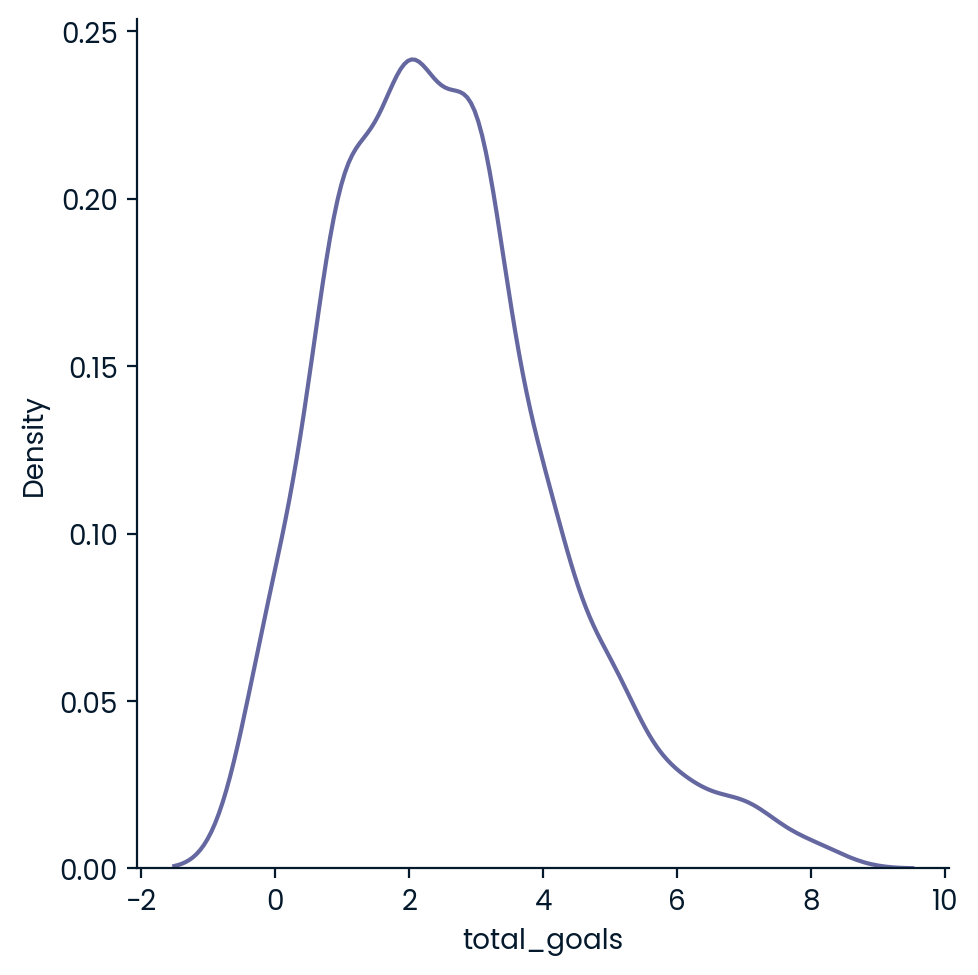

In [271]:
#Checking for whether data is normally distributed
sns.displot(x='total_goals', kind='kde', data=men_results)
plt.show()

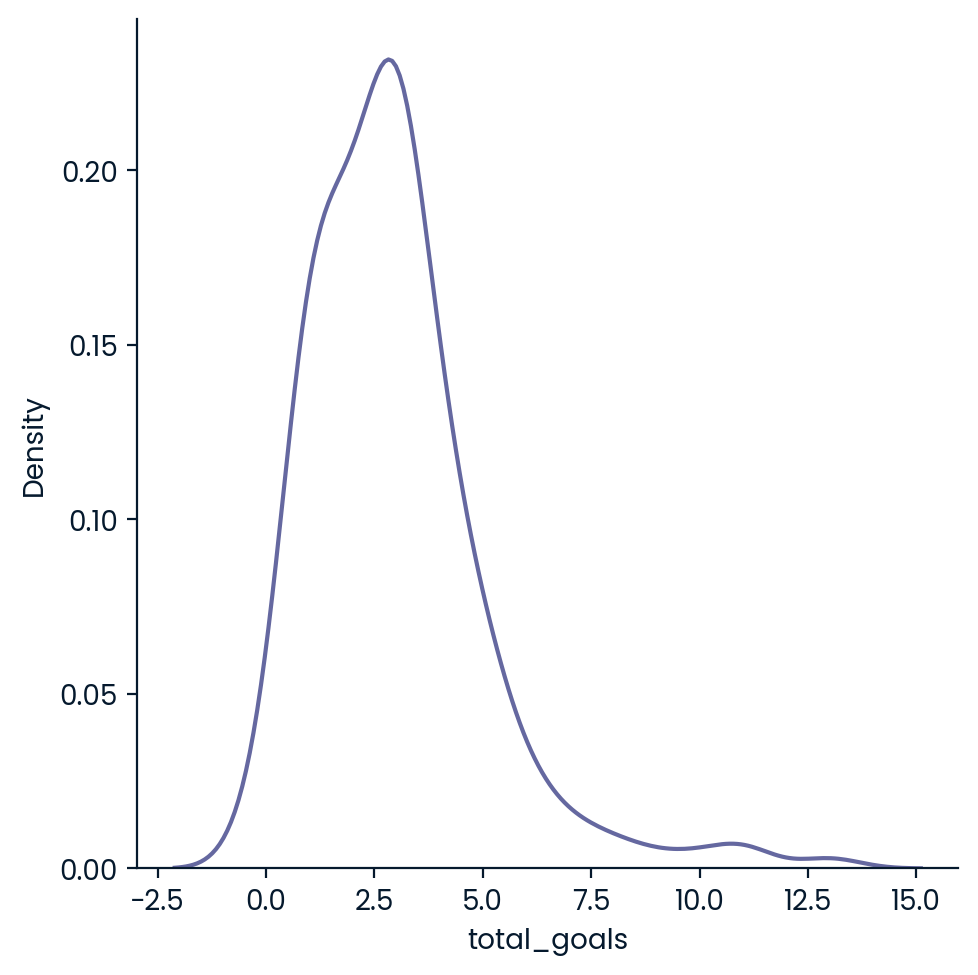

In [272]:
sns.displot(x='total_goals', kind='kde', data=women_results)
plt.show()

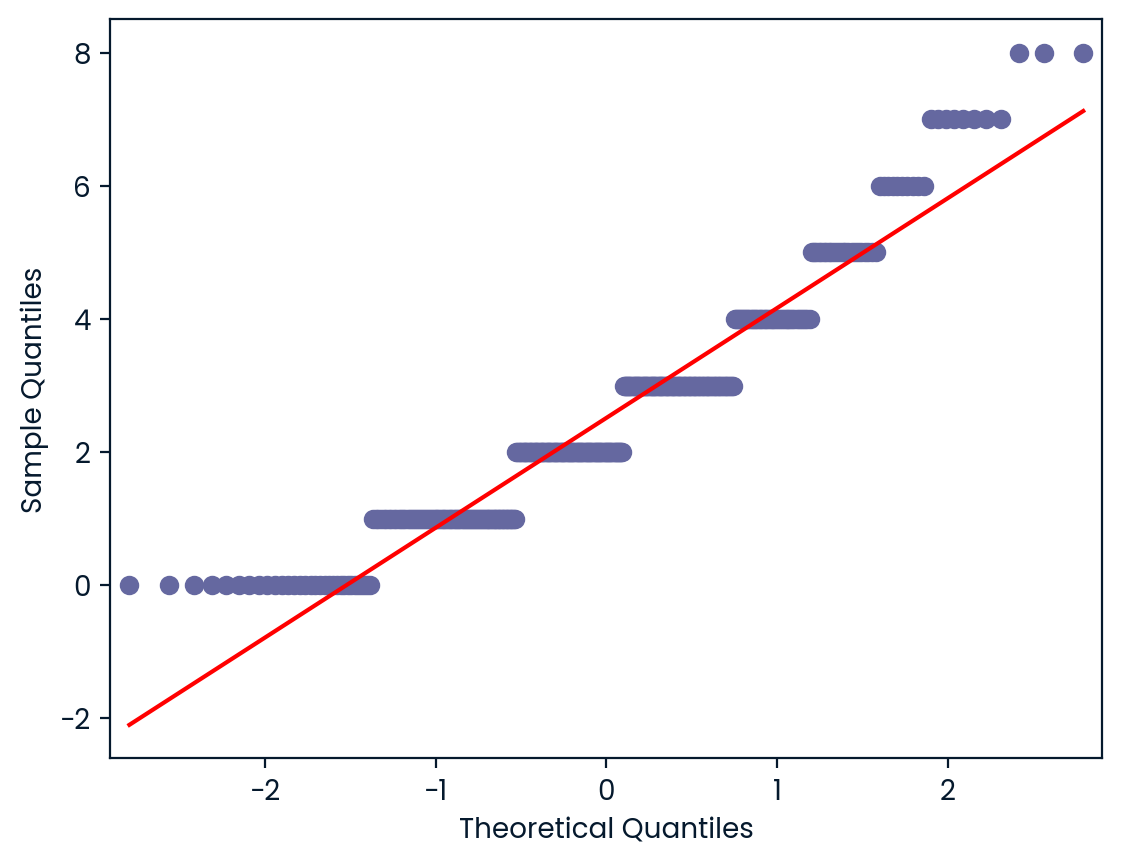

In [273]:
qqplot(men_results['total_goals'], line='s', dist=norm)
plt.show()

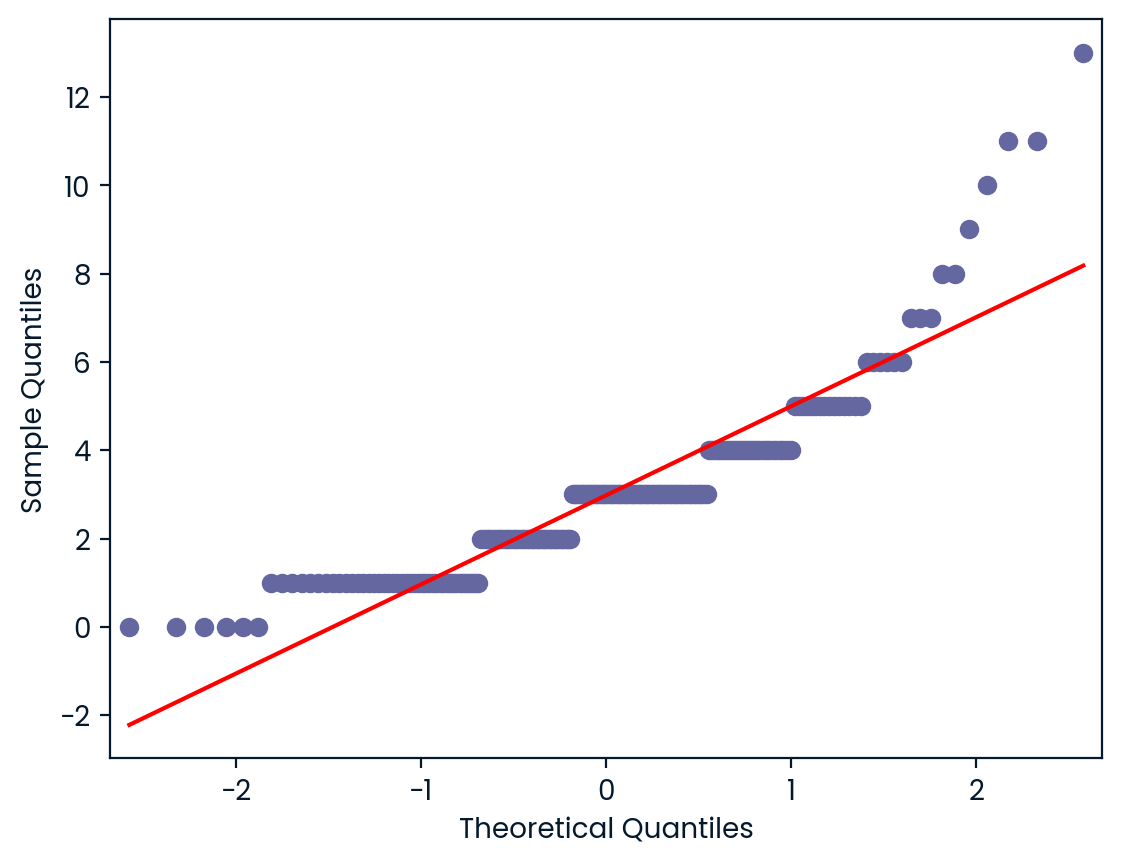

In [274]:
qqplot(women_results['total_goals'], line='s', dist=norm)
plt.show()

In [275]:
alpha = 0.01
stat_men, p_men = shapiro(men_results['total_goals'])
stat_women, p_women = shapiro(women_results['total_goals'])
print(f"p_men: {p_men} test_stat_men: {round(stat_men,4)}")
print(f"p_women: {p_women} test_stat_women: {round(stat_women,4)}")

p_men: 8.894154401688226e-13 test_stat_men: 0.9266
p_women: 3.8905201759850683e-13 test_stat_women: 0.8491


In [276]:
# Since p values < alpha, our distributions are not normal, so we use non-parametric tests

In [277]:
# H_0: Mean number of goals scored in women's international soccer matches is the same as men's
# H_A: Mean number of goals scored in women's international soccer matches is greater than men's

In [278]:
# Transform the data for the pingouin Mann-Whitney U t-test
all_matches_subset = all_matches[["total_goals", "gender"]]
all_matches_subset_wide = all_matches_subset.pivot(columns="gender", values="total_goals")

In [279]:
# Perform right-tailed Wilcoxon-Mann-Whitney test with pingouin
results_pg = pingouin.mwu(x=all_matches_subset_wide["Female"],
                          y=all_matches_subset_wide["Male"],
                          alternative="greater")
print(results_pg)

       U-val alternative     p-val       RBC      CLES
MWU  43273.0     greater  0.005107 -0.126901  0.563451


In [280]:
# Extract p-value as a float
p_val = results_pg["p-val"].values[0]

In [281]:
alpha = 0.01
result = p_val < alpha
if result == True:
    result = 'reject'
else:
    result = 'fail to reject'

In [282]:
result_dict = {'p_val': p_val, 'result': result}
print(result_dict)

{'p_val': 0.005106609825443641, 'result': 'reject'}


### Since we reject the null hypothesis, we can safely conclude that the mean number of goals scored in women's matches is greater than men's!!! 